In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.signal import correlate
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from scipy.stats import binned_statistic
from scipy.signal import correlation_lags

In [2]:
genotype = 'R60D05>sytGCaMP7f'
celltype = 'EPG-syt7f-EB'
trial_condition = 'cl'

In [3]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,run_ANOVA_for_comparing_across_genotypes
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import offset_calculation
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude_V3, calcualteBumpAmplitude_V4,calculateBumpWidth_v1
from fly2p_function_TQ.imaging_2p_preprocessing import low_pass_filter_TQ, get_dff_array, normalizing_dff_array

In [4]:
# Dictionary to hold data for each fly
fly_data = {}
pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/delta7_imaging_delta7_perturbation/delta7_vglut_or_Glucl/R55G08_VGlut_syt7f/dark')
ROI_type = 2

# Process each file in the directory
for filename in os.listdir(pooled_directory):
    if filename.endswith('.csv'):
        # Extract the fly identifier (assuming format like 'TQfly109-001.csv')
        fly_id = filename.split('-')[0]  # This splits the filename and takes the first part
        file_path = os.path.join(pooled_directory, filename)
        current_file = pd.read_csv(file_path)

        # Check if the fly_id already has an entry in the dictionary
        if fly_id not in fly_data:
            fly_data[fly_id] = {
                'lagged_Bump_amplitude_z_smooth': [],
                'lagged_Bump_amplitude_max_min_z_smooth': [],
                'lagged_PVA_strength': [],
                'lagged_Bump_width' :[],
                'lagged_Bump_width_normalized' :[],
                'Angular_speed' :[],
                'mean_PVA_strength_per_trial' : [],
                'Average_bump_shape':  pd.DataFrame(),
                'Average_bump_shape_normalized':  pd.DataFrame(),
                'FWHM':[],
                'FWHM_normalized':[]
     
            }

        #Get time info
        volume_cycle = len(current_file )
        volume_time = current_file['Time_Stamp'][1]
        volume_rate = 1/volume_time
        time_array_imaging = np.arange(volume_cycle)/volume_rate
        #Get necessary parameters
        PVA_Unwrapped_Radian = current_file['Unwrapped_Radian'].values
        PVA_Angle = current_file['PVA_Angle'].values
        PVA_Radian = current_file['PVA_Radian'].values
        Angular_velocity = current_file['Angular_Velocity'].values
        PVA_strength = current_file['PVA_strength'].values
        Bump_amplitude = current_file['Bump_amplitude'].values
        Unwrapped_heading = current_file['Unwrapped_Bar_Position/Heading'].values
        Wrapped_heading = current_file['Bar_Position/Heading'].values
    
        dff_normalized_8_roi = np.array([current_file[f'dFF_Roi_{i}'] for i in range(1, 9)]).T
        dff_normalized_8_roi_shifted = np.zeros((len(current_file['dFF_Roi_1']), 8))
        for i in range(len(current_file['F_Roi_1'])):
            dff_normalized_8_roi_shifted[i,0]= current_file['dFF_Roi_5'][i]
            dff_normalized_8_roi_shifted[i,1]= current_file['dFF_Roi_6'][i]
            dff_normalized_8_roi_shifted[i,2]= current_file['dFF_Roi_7'][i]
            dff_normalized_8_roi_shifted[i,3]= current_file['dFF_Roi_8'][i]
            dff_normalized_8_roi_shifted[i,4]= current_file['dFF_Roi_1'][i]
            dff_normalized_8_roi_shifted[i,5]= current_file['dFF_Roi_2'][i]
            dff_normalized_8_roi_shifted[i,6]= current_file['dFF_Roi_3'][i]
            dff_normalized_8_roi_shifted[i,7]= current_file['dFF_Roi_4'][i]
        dff_normalized_8_roi_shifted = dff_normalized_8_roi_shifted.transpose()
        
        if ROI_type == 1: 
            columns = ['Raw_F_5', 'Raw_F_14', 'Raw_F_6', 'Raw_F_15', 'Raw_F_7', 'Raw_F_16','Raw_F_8','Raw_F_9','Raw_F_1','Raw_F_10','Raw_F_2','Raw_F_11','Raw_F_3','Raw_F_12','Raw_F_4', 'Raw_F_13']
        #For delta7 type ROI
        elif ROI_type == 2:
            columns = ['Raw_F_5', 'Raw_F_13', 'Raw_F_6', 'Raw_F_14', 'Raw_F_7', 'Raw_F_15', 'Raw_F_8', 'Raw_F_16','Raw_F_1','Raw_F_9','Raw_F_2','Raw_F_10','Raw_F_3','Raw_F_11','Raw_F_4','Raw_F_12']
        # For EB ROI: 
        else:
            columns = ['Raw_F_1', 'Raw_F_2', 'Raw_F_3', 'Raw_F_4', 'Raw_F_5', 'Raw_F_6', 'Raw_F_7', 'Raw_F_8','Raw_F_9','Raw_F_10','Raw_F_11','Raw_F_12','Raw_F_13','Raw_F_14','Raw_F_15','Raw_F_16']
        raw_data_16_ROI = [current_file[col].to_numpy() for col in columns]
        raw_data_16_ROI = np.array(raw_data_16_ROI).T
        dff_16_roi = get_dff_array(raw_F_array = raw_data_16_ROI, ROI_num = 16, F_zero_cutoff = 0.05, if_plot =0)
        dff_normalized_16_roi = normalizing_dff_array(dff_16_roi,ROI_num= 16, normalize_cutoff= 0.95,if_plot =0)
        #Calculate bump width
        Bump_width_current = calculateBumpWidth_v1(dff_16_roi,16)
        Bump_width_current_normalized = calculateBumpWidth_v1(dff_normalized_16_roi,16)
        
        #dff_normalized_16_roi_shifted = np.column_stack(dff_normalized_16_roi)
        df_dff_in_ROI_16_shifted_peak_centered = np.zeros((len(dff_16_roi.T), len(dff_16_roi.T[0])))
        df_dff_in_ROI_16_shifted_peak_centered_normalized = np.zeros((len(dff_normalized_16_roi.T), len(dff_normalized_16_roi.T[0])))
        shifted_by_all = []
        for i in range(len(dff_normalized_8_roi_shifted[0])):
            original_order = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
            
            current_peak = np.argmax(dff_16_roi.T[:,i])
            current_peak_normalized = np.argmax(dff_normalized_16_roi.T[:,i])
            
            shift_by = current_peak - 8
            shift_by_normalized = current_peak_normalized - 8
            
            shifted_order = original_order[shift_by % len(original_order):] + original_order[:shift_by % len(original_order)]
            shifted_order_normalized = original_order[shift_by_normalized % len(original_order):] + original_order[:shift_by_normalized % len(original_order)]
            
            df_dff_in_ROI_16_shifted_peak_centered[:,i] = dff_16_roi.T[shifted_order,i]
            df_dff_in_ROI_16_shifted_peak_centered_normalized[:,i] = dff_normalized_16_roi.T[shifted_order_normalized,i]
            shifted_by_all.append(shift_by)
    
        average_bump_shape = np.mean(df_dff_in_ROI_16_shifted_peak_centered, axis=1)
        average_bump_shape =pd.DataFrame(average_bump_shape)
        average_bump_shape_normalized = np.mean(df_dff_in_ROI_16_shifted_peak_centered_normalized, axis=1)
        average_bump_shape_normalized = pd.DataFrame(average_bump_shape_normalized)
 

        
        
        Angular_speed_degrees =  np.abs(Angular_velocity) * 180/np.pi
        
        
        #Get persistence period
        persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
        
        
        #Calculate and plot difference throughout the stop period
        difference_during_stop = []
        current_difference_during_stop = []
        #plt.figure(figsize= (25,7))
        for current_index in range(len(persistence_stop_index_and_length)):
            current_stop_PVA = PVA_Angle[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
            current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
            current_difference_during_stop = PVA_Angle[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
            #Modify the value so angle difference will never be different more than 180 degrees
            for j in range(len(current_difference_during_stop)):
                if np.abs(current_difference_during_stop[j]) > 180:
                    if current_difference_during_stop[j] < 0:
                        current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
                    else:
                        current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
            difference_during_stop.append(current_difference_during_stop)
    
        # calculate bump amplitude by getting the normalized dff at current PVA angle 
        Bump_amplitude_V3, Bump_amplitude_V3_opposite = calcualteBumpAmplitude_V3(dff_normalized_8_roi,PVA_Radian)
        Bump_amplitude_V4 =  calcualteBumpAmplitude_V4(Bump_amplitude_V3,dff_normalized_8_roi,PVA_Radian,persistence_stop_index_and_length)
    
        Bump_amplitude_smooth_for_speed_cor_V3 = gaussian_filter1d(Bump_amplitude_V3, sigma =5)
        Bump_amplitude_smooth_for_speed_cor_V4 = gaussian_filter1d(Bump_amplitude_V4, sigma =5)
        Bump_amplitude_smooth_for_speed_cor_max_min = gaussian_filter1d(Bump_amplitude, sigma =5)
        Bump_amplitude_z_smooth_for_speed_cor_V3 = zscore(Bump_amplitude_smooth_for_speed_cor_V3)
        Bump_amplitude_z_smooth_for_speed_cor_V4 = zscore(Bump_amplitude_smooth_for_speed_cor_V4)
        Bump_amplitude_smooth_for_speed_cor_max_min =zscore(Bump_amplitude_smooth_for_speed_cor_max_min)
       
    
   
        # Calculate cross-correlation within the allowed lags range
        cross_corr = correlate(Angular_speed_degrees, Bump_amplitude_z_smooth_for_speed_cor_V3, mode='full')
        lags = correlation_lags(Angular_speed_degrees.size,  Bump_amplitude_z_smooth_for_speed_cor_V3.size, mode="full")
                                  
        #find the middle index to consider the frame on both side till max shift frame (1s)
        #max_shift_frame = int(volume_rate)
        #middle_index = int(len(lags)/2)
        #lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
        #correlation_short = cross_corr[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
        #lag = lags_short[np.argmax(correlation_short)]
        #if lag > 0:
            #lag = lags_short[np.argmax(correlation_short[0:int((len(correlation_short)-1)/2+1)])]
        lag = int(-0.3/volume_time)
        
     
        # Apply the lag only to Bump_amplitude_z_smooth_for_speed_cor
    
        #shift back tne bump_amplitude or PVA strength by drop the lag frame at the beginning
        lagged_Bump_amplitude_z_smooth_for_speed_cor = Bump_amplitude_z_smooth_for_speed_cor_V3[-lag:]
        lagged_Bump_amplitude_max_min_z_smooth_for_speed_cor = Bump_amplitude_smooth_for_speed_cor_max_min[-lag:]
        Angular_speed_degrees = Angular_speed_degrees[:len(lagged_Bump_amplitude_z_smooth_for_speed_cor)]
        lagged_PVA_strength_for_speed_cor = PVA_strength[-lag:]
        lagged_Bump_width_for_spped_cor = Bump_width_current[-lag:]
        lagged_Bump_width_normalized_for_spped_cor = Bump_width_current_normalized[-lag:]
        
                
        mean_pva_strength = np.array([np.mean(PVA_strength)])  # Make it a one-dimensional array
        # Append or concatenate new session data to existing fly data
        if len(fly_data[fly_id]['lagged_Bump_amplitude_z_smooth']) > 0:
            fly_data[fly_id]['lagged_Bump_amplitude_z_smooth'] = np.concatenate((fly_data[fly_id]['lagged_Bump_amplitude_z_smooth'], lagged_Bump_amplitude_z_smooth_for_speed_cor))
            fly_data[fly_id]['lagged_Bump_amplitude_max_min_z_smooth']  = np.concatenate((fly_data[fly_id]['lagged_Bump_amplitude_max_min_z_smooth'], lagged_Bump_amplitude_max_min_z_smooth_for_speed_cor))
            fly_data[fly_id]['Angular_speed'] = np.concatenate((fly_data[fly_id]['Angular_speed'], Angular_speed_degrees))
            fly_data[fly_id]['lagged_PVA_strength'] = np.concatenate((fly_data[fly_id]['lagged_PVA_strength'], lagged_PVA_strength_for_speed_cor))
            fly_data[fly_id]['lagged_Bump_width'] = np.concatenate((fly_data[fly_id]['lagged_Bump_width'], lagged_Bump_width_for_spped_cor))
            fly_data[fly_id]['lagged_Bump_width_normalized'] = np.concatenate((fly_data[fly_id]['lagged_Bump_width_normalized'], lagged_Bump_width_normalized_for_spped_cor))
            fly_data[fly_id]['mean_PVA_strength_per_trial'] = np.concatenate((fly_data[fly_id]['mean_PVA_strength_per_trial'], mean_pva_strength))
            fly_data[fly_id]['Average_bump_shape'] = pd.concat([fly_data[fly_id]['Average_bump_shape'], average_bump_shape ],ignore_index=True, axis =1) 
            fly_data[fly_id]['Average_bump_shape_normalized'] = pd.concat([fly_data[fly_id]['Average_bump_shape_normalized'], average_bump_shape_normalized],ignore_index=True, axis =1) 
            fly_data[fly_id]['FWHM'] = np.concatenate((fly_data[fly_id]['FWHM'], np.array([np.mean(Bump_width_current)])))
            fly_data[fly_id]['FWHM_normalized'] = np.concatenate((fly_data[fly_id]['FWHM_normalized'],np.array([np.mean(Bump_width_current_normalized)])))
        else:
            fly_data[fly_id]['lagged_Bump_amplitude_z_smooth'] =  lagged_Bump_amplitude_z_smooth_for_speed_cor
            fly_data[fly_id]['lagged_Bump_amplitude_max_min_z_smooth'] =  lagged_Bump_amplitude_max_min_z_smooth_for_speed_cor
            fly_data[fly_id]['Angular_speed'] = Angular_speed_degrees
            fly_data[fly_id]['lagged_PVA_strength'] = lagged_PVA_strength_for_speed_cor
            fly_data[fly_id]['lagged_Bump_width'] = lagged_Bump_width_for_spped_cor
            fly_data[fly_id]['lagged_Bump_width_normalized'] = lagged_Bump_width_normalized_for_spped_cor
            #Average PVA_strength per trial
            fly_data[fly_id]['mean_PVA_strength_per_trial'] = mean_pva_strength
            fly_data[fly_id]['Average_bump_shape'] = average_bump_shape 
            fly_data[fly_id]['Average_bump_shape_normalized'] = average_bump_shape_normalized
            fly_data[fly_id]['FWHM'] = np.array([np.mean(Bump_width_current)])
            fly_data[fly_id]['FWHM_normalized'] = np.array([np.mean(Bump_width_current_normalized)])
           
        
        
        

In [5]:
fly_data 

{'TQfly483': {'lagged_Bump_amplitude_z_smooth': array([-1.21074152, -1.18154441, -1.14321375, ...,  0.67328716,
          0.83066348,  0.91148877]),
  'lagged_Bump_amplitude_max_min_z_smooth': array([-0.32041524, -0.3136182 , -0.3056038 , ...,  1.38895305,
          1.43197777,  1.4539165 ]),
  'lagged_PVA_strength': array([1.10138245, 0.90873162, 0.93725744, ..., 2.14477177, 2.23455603,
         2.17877612]),
  'lagged_Bump_width': array([ 90. ,  22.5,  45. , ..., 157.5, 135. , 157.5]),
  'lagged_Bump_width_normalized': array([180. , 202.5, 202.5, ..., 225. , 202.5, 225. ]),
  'Angular_speed': array([16.48977921, 20.35862887, 34.29083684, ...,  1.56526039,
          3.57227188,  1.76584828]),
  'mean_PVA_strength_per_trial': array([1.24251218, 1.48228455, 1.34157692]),
  'Average_bump_shape':            0         1         2
  0   0.410324  0.641781  0.634905
  1   0.528718  0.684642  0.542354
  2   0.335994  0.617134  0.671705
  3   0.450313  0.743708  0.816654
  4   0.432655  0.8518

In [12]:
# Initialize an empty list to store the results
fwhm_data = []

# Loop through each entry in the dictionary
for fly_id, data in fly_data.items():
    # Calculate the average for 'FWHM' and 'FWHM_normalized'
    avg_fwhm = np.mean(data['FWHM'])
    avg_fwhm_normalized = np.mean(data['FWHM_normalized'])
    
    # Append a dictionary with the fly_id and averaged values
    fwhm_data.append({
        'Fly_ID': fly_id,
        'FWHM': avg_fwhm,
        'FWHM_normalized': avg_fwhm_normalized
    })

# Convert the list of dictionaries into a DataFrame
fwhm_df = pd.DataFrame(fwhm_data)

# Set the 'Fly_ID' as the index (optional, depending on your needs)
fwhm_df.set_index('Fly_ID', inplace=True)

In [6]:
fwhm_df.to_csv('/home/tianhaoqiu/Pictures/Screenshots/FWHM_delta7_syt6s_empty_shi_31_dark.csv')

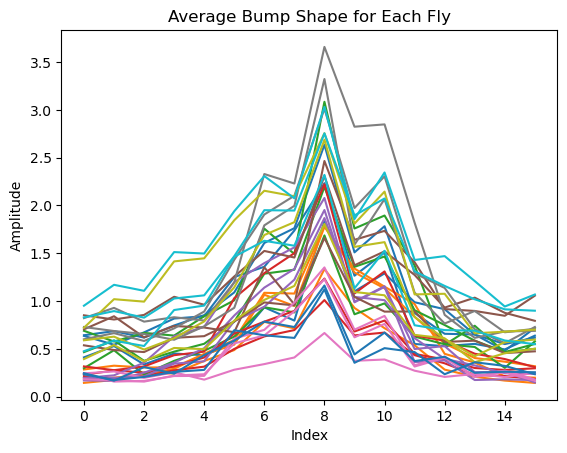

In [13]:
def plot_average_bump_shape(flydata):
    # Get the colormap using the new method (without specifying the length)
    cmap = plt.colormaps.get_cmap('tab10')

    # Iterate through the data and plot each fly's bump shape
    for i, (fly_id, data) in enumerate(flydata.items()):
        bump_shape = data['Average_bump_shape']

        # Plot each column of the 'Average_bump_shape' DataFrame
        for col in bump_shape.columns:
            plt.plot(bump_shape.index, bump_shape[col], label=f'{fly_id} - Column {col}', color=cmap(i % 10))  # Modulo to handle more than 10 flies

    # Add labels and legend
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.title('Average Bump Shape for Each Fly')
    plt.show()

# Call the function
plot_average_bump_shape(fly_data)

In [14]:
def correaltion_across_speed_range(flydata, bin_Width, bin_Edges_low, bin_Edges_up,x_column,y_column):
    # Define the bin edges with a bin width of 5
    bin_width = bin_Width
    bin_edges = np.arange(bin_Edges_low, bin_Edges_up + bin_width, bin_width)

    # Prepare a DataFrame to store results
    binned_results_df = pd.DataFrame(index=bin_edges[:-1] + 0.5 * bin_width)
    
    # Process each fly's data
    for fly_id, data in flydata.items():
        x_data = data[x_column]
        y_data = data[y_column]

        # Calculate binned statistics
        binned_stats = binned_statistic(x_data, y_data, statistic='mean', bins=bin_edges)
        binned_counts = binned_statistic(x_data, y_data, statistic='count', bins=bin_edges).statistic

        # Check the number of values in each bin and raise warnings if below threshold
        
        warning_threshold = 10
        for bin_idx, count in enumerate(binned_counts):
            if count < warning_threshold:
                print(f"Warning: For fly {fly_id}, bin {bin_edges[bin_idx]}-{bin_edges[bin_idx+1]} has only {int(count)} values, which is below the threshold of {warning_threshold}.")

        # Extract the mean bump width per bin
        mean_Bump_width_per_bin = binned_stats.statistic

        # Store results in the DataFrame under the fly's identifier
        binned_results_df[fly_id] = mean_Bump_width_per_bin

        # Plotting (optional, can be commented out if only the DataFrame is needed)
        valid_bins = ~np.isnan(mean_Bump_width_per_bin)
        bin_centers = binned_stats.bin_edges[:-1] + 0.5 * bin_width
        correlation_coefficient = np.corrcoef(bin_centers[valid_bins], mean_Bump_width_per_bin[valid_bins])[0, 1]

        plt.figure(figsize=(15, 5))
        plt.bar(bin_centers[valid_bins], mean_Bump_width_per_bin[valid_bins], width=bin_width, align='center', edgecolor='black')
        plt.xlim(0, np.max(bin_edges))
        plt.xlabel(f'{x_column} (°/sec)')
        plt.ylabel(f'{y_column} (units)')
        plt.title(f'{fly_id} - Binned Mean {y_column} vs. {x_column}\nCorrelation: {correlation_coefficient:.2f}')
        plt.show()
    
    return binned_results_df


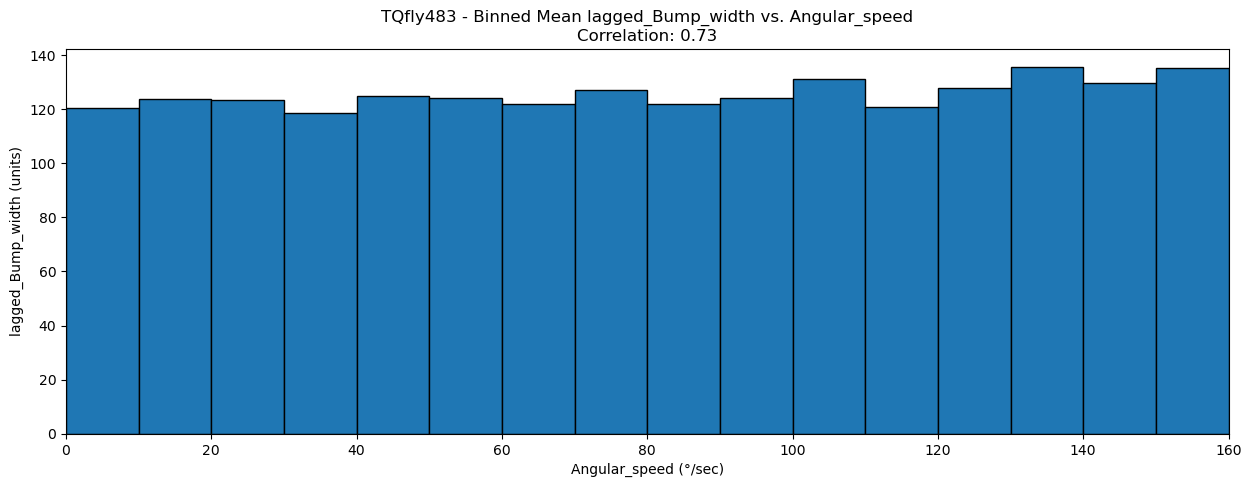

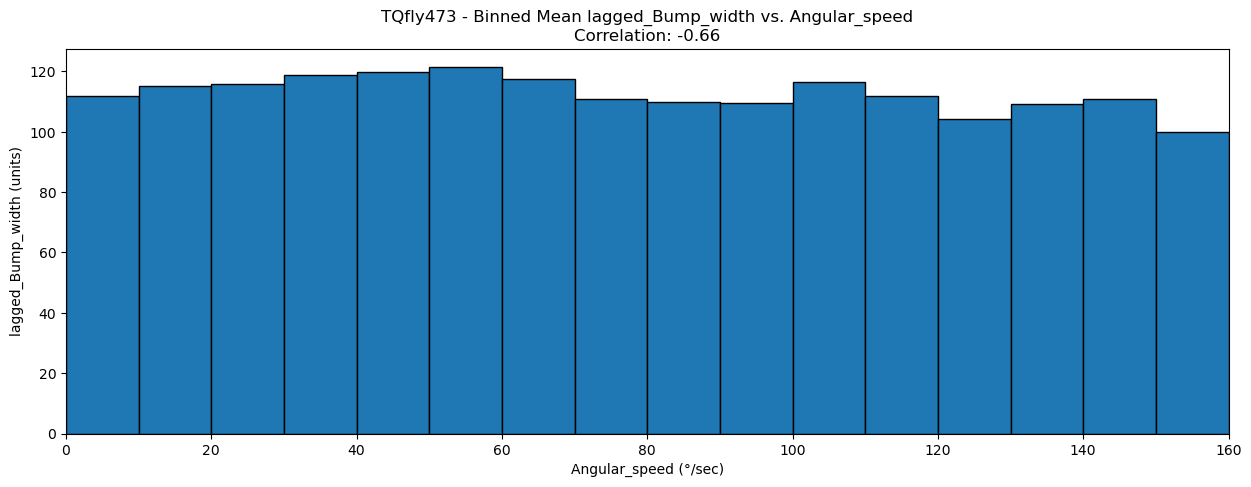

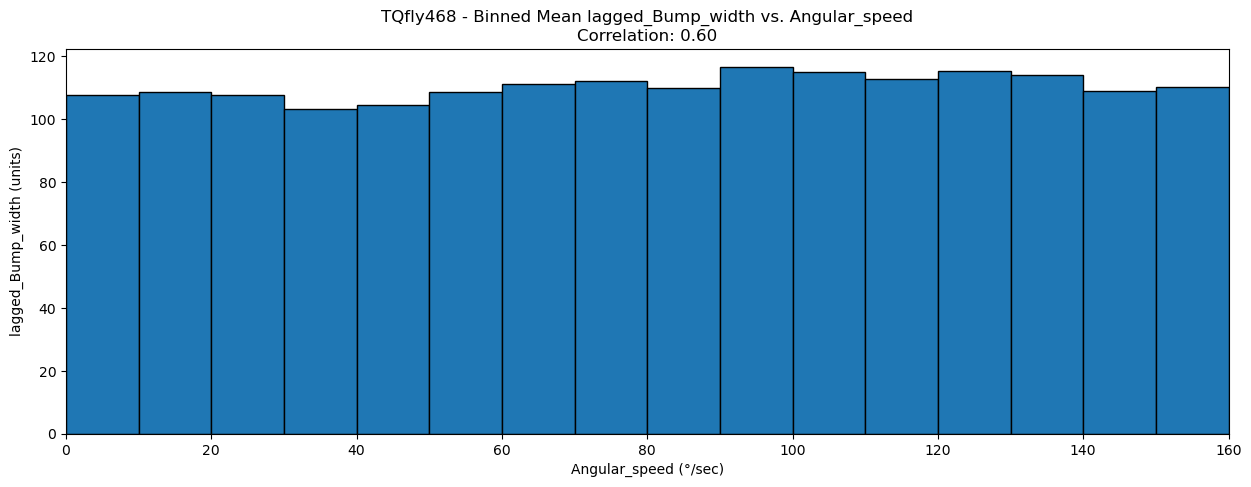

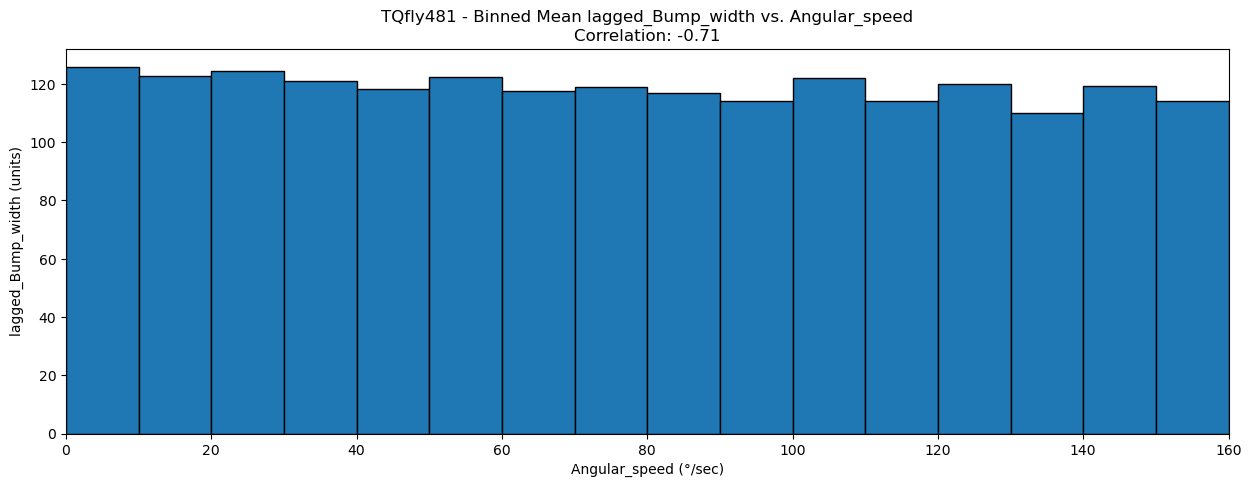

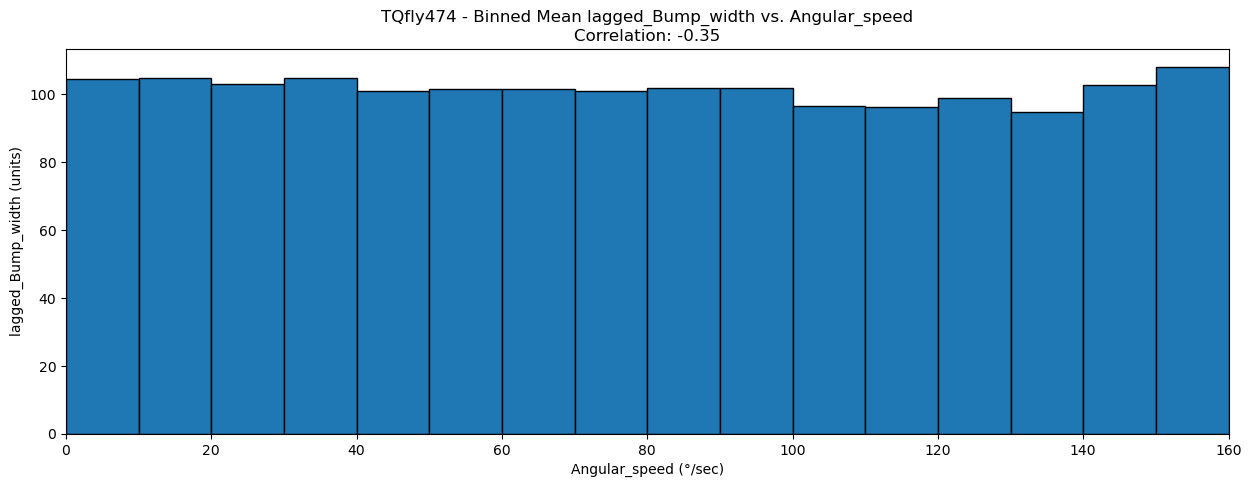

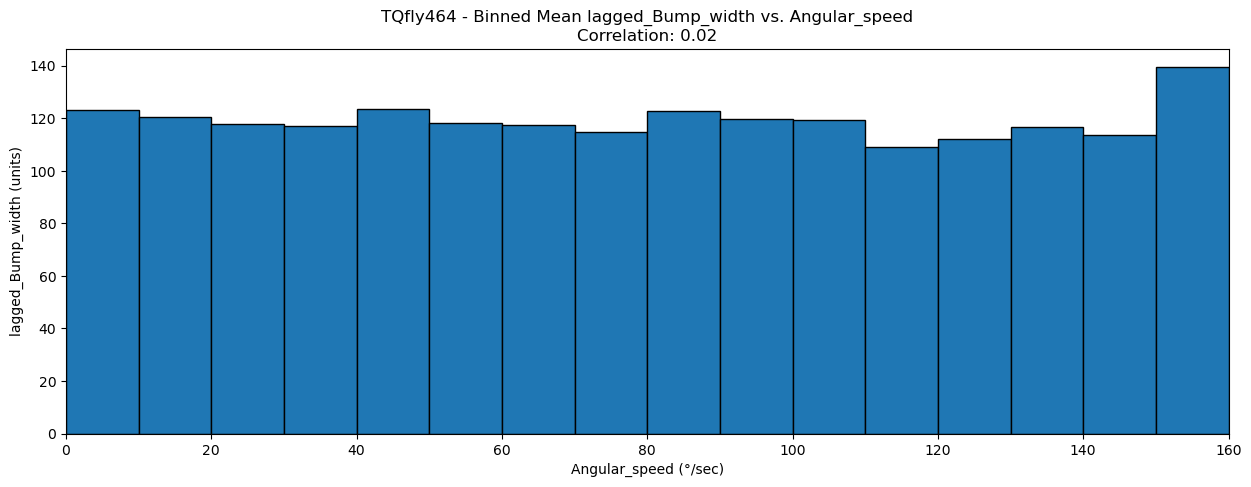

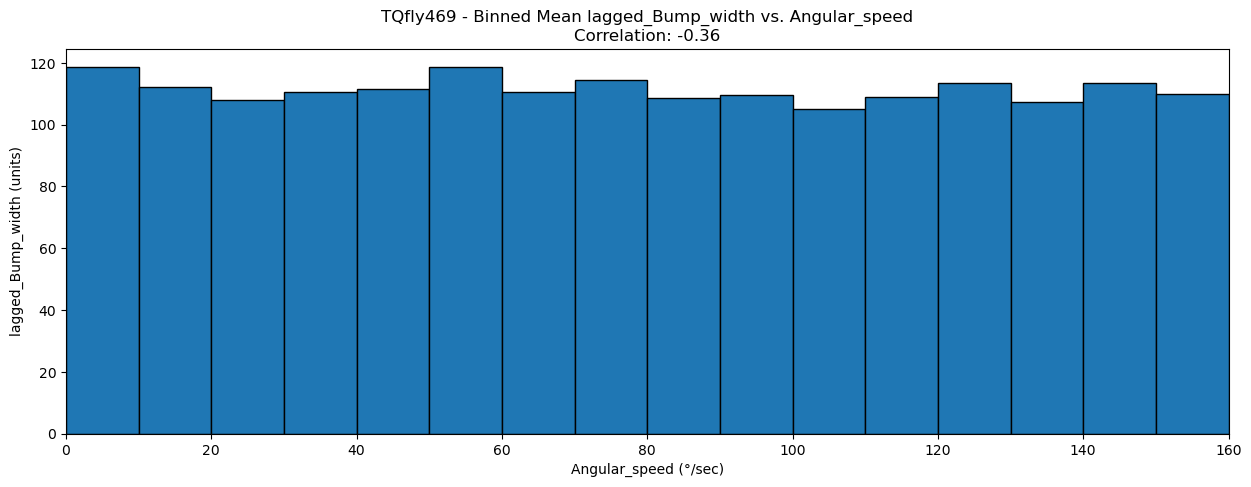

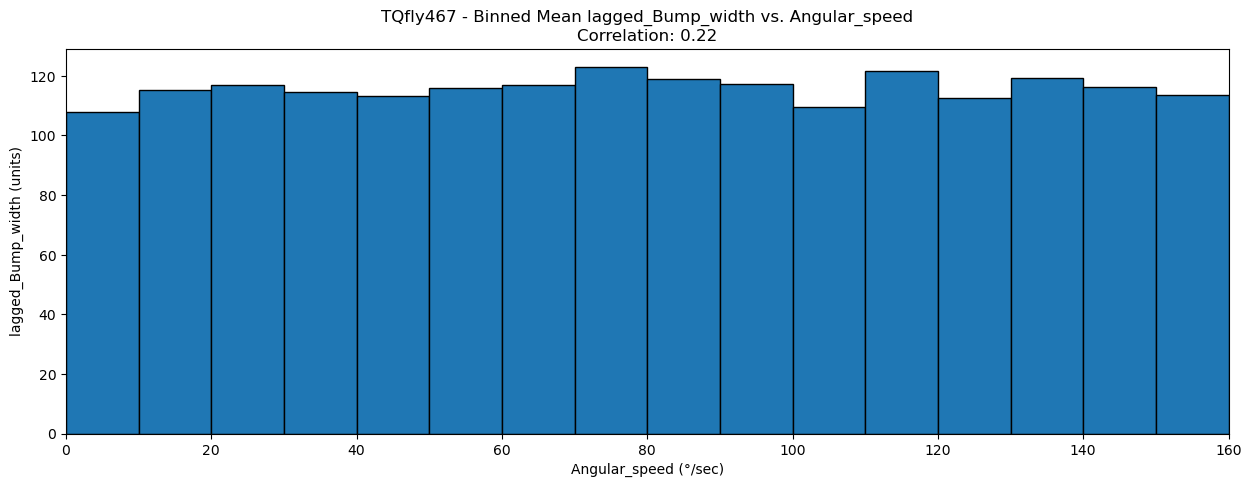

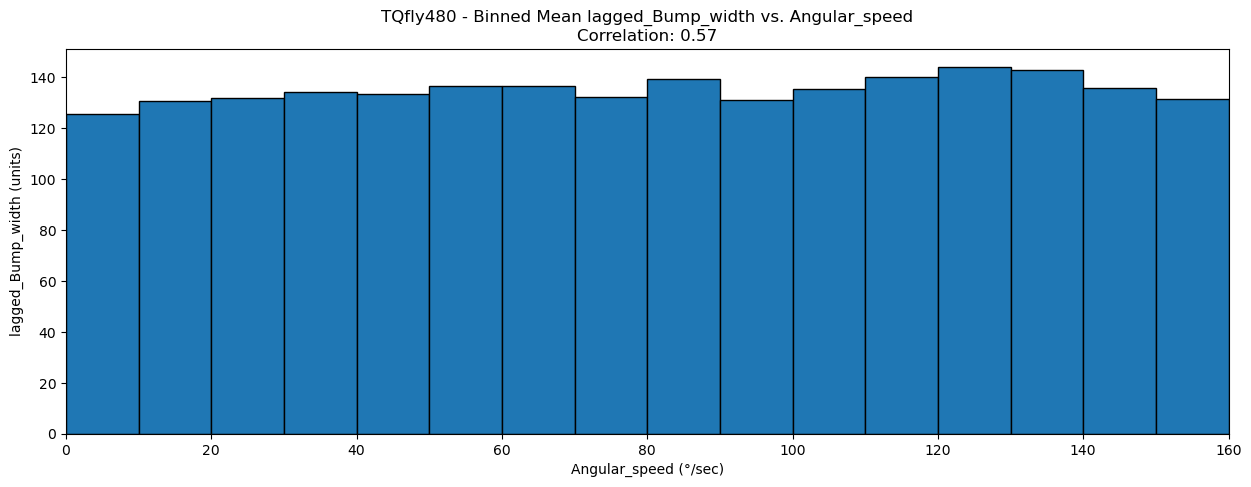

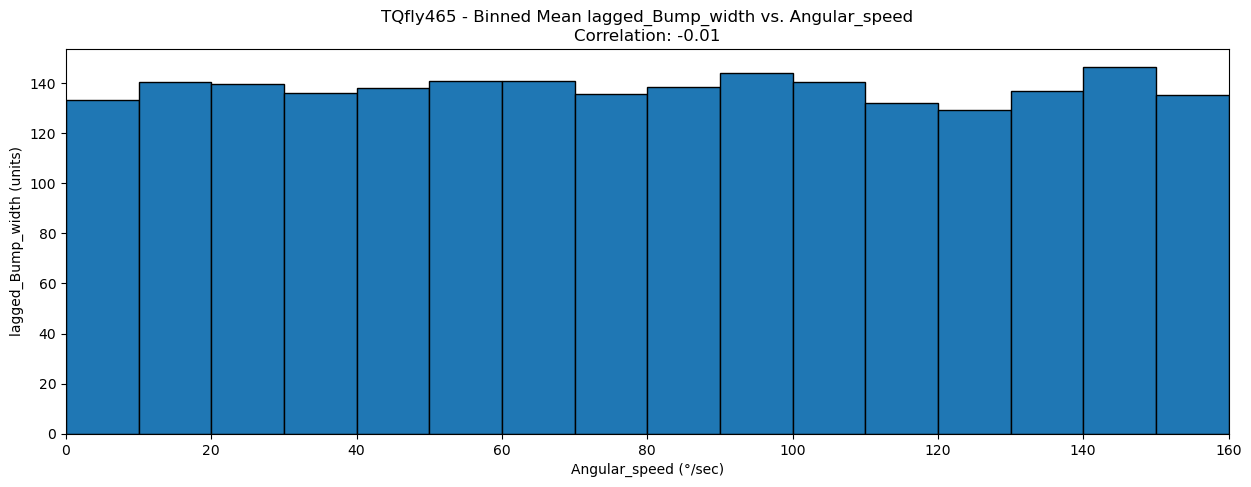

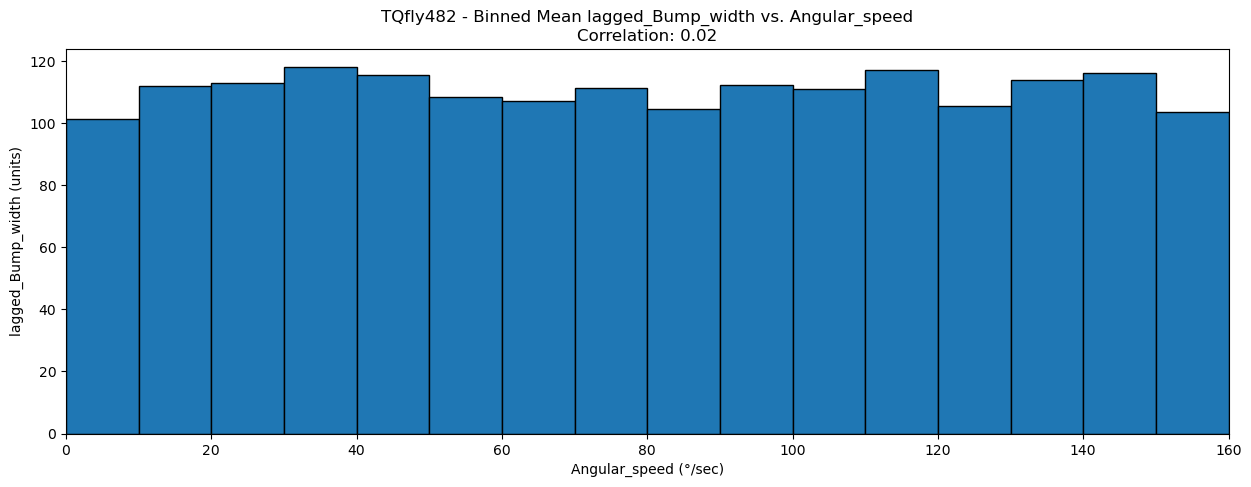

In [15]:
binned_results_df = correaltion_across_speed_range(fly_data, bin_Width=10, bin_Edges_low=0, bin_Edges_up=160,x_column = 'Angular_speed',y_column='lagged_Bump_width')

In [16]:
binned_results_df.to_csv('/home/tianhaoqiu/Pictures/Screenshots/binned_results_delta7_Bump_width_delta7_vglut_dark_0_160_10.csv', index=False)

In [17]:
pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df= pd.read_csv('/home/tianhaoqiu/Pictures/Screenshots/binned_results_delta7_Bump_width_delta7_attp40_dark_0_160_10.csv')
pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df= pd.read_csv('/home/tianhaoqiu/Pictures/Screenshots/binned_results_delta7_Bump_width_delta7_vglut_dark_0_160_10.csv')

In [18]:
pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns = range(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns))
pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns = range(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns))

In [19]:
angular_speed_array = np.arange(0, 160, 10)
#angular_speed_array = np.arange(0, 20, 1)

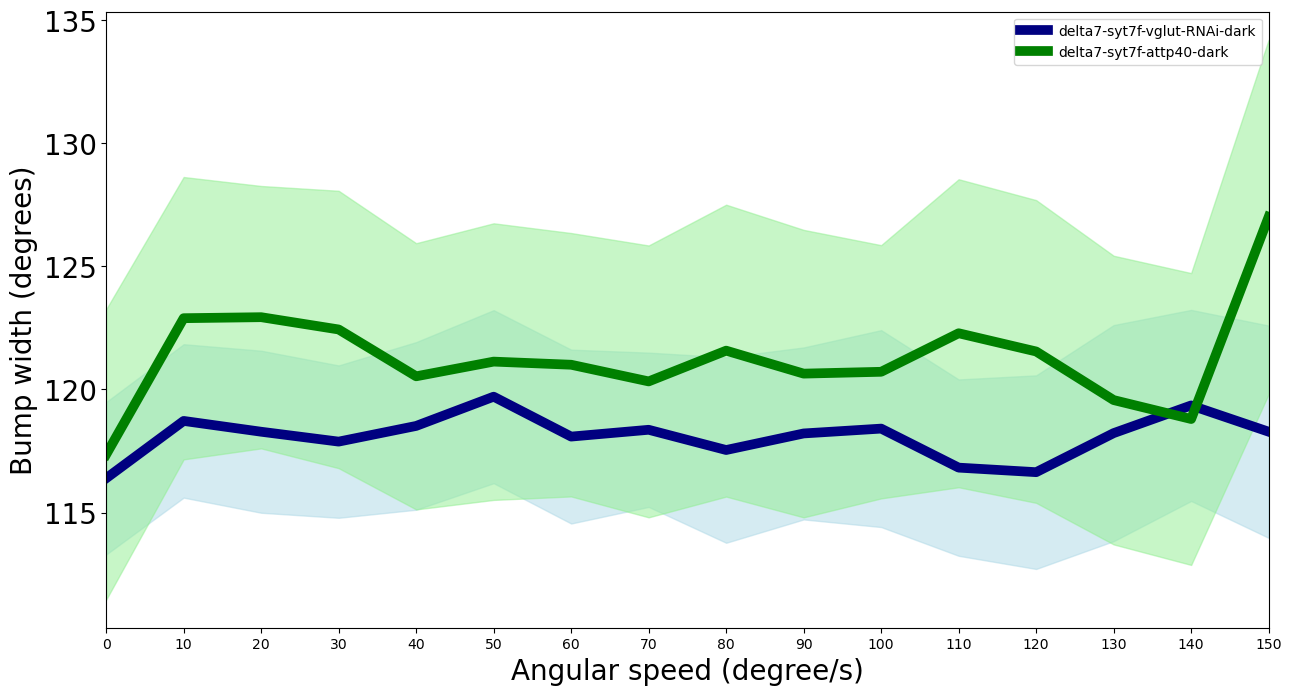

In [20]:
# Calculate mean and SEM for the first DataFrame (blue)
mean_delta7 = pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.mean(axis=1)
sem_delta7 = pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.sem(axis=1)

# Calculate mean and SEM for the second DataFrame (green)
mean_EPG = pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.mean(axis=1)
sem_EPG = pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.sem(axis=1)

# Plot mean and SEM for the first DataFrame (blue)
plt.figure(figsize=(15, 8))
plt.plot(mean_delta7, linewidth=7, color='navy', label='delta7-syt7f-vglut-RNAi-dark')
plt.fill_between(mean_delta7.index, mean_delta7 - sem_delta7, mean_delta7 + sem_delta7, color='lightblue', alpha=0.5)

# Plot mean and SEM for the second DataFrame (green)
plt.plot(mean_EPG, linewidth=7, color='green', label='delta7-syt7f-attp40-dark')
plt.fill_between(mean_EPG.index, mean_EPG - sem_EPG, mean_EPG + sem_EPG, color='lightgreen', alpha=0.5)


plt.xticks(mean_delta7.index,angular_speed_array,size = 10)
plt.yticks(size = 20)
plt.xlim(0,15)
#plt.ylim(100,220)

# Set labels and title
plt.xlabel('Angular speed (degree/s)', size = 20)
#plt.ylabel('Bump amplitude (max-min) (z-scored)', size = 20)
#plt.ylabel('PVA strength', size = 20)
plt.ylabel('Bump width (degrees)', size = 20)
#plt.title('Mean Bump Amplitude with SEM')
plt.legend()
plt.show()

In [560]:
delta7_correlation_coefficient = np.zeros(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns))
EPG_correlation_coefficient = np.zeros(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns))

In [561]:
for i in range(len(pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df.columns)):
    delta7_correlation_coefficient[i] = np.corrcoef(angular_speed_array,pooled_bump_amplitudev3_VS_AV_delta7_PB_syt_df[i])[0, 1]
for i in range(len(pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df.columns)):
    EPG_correlation_coefficient[i] = np.corrcoef(angular_speed_array,pooled_bump_amplitudev3_VS_AV_EPG_PB_syt_df[i])[0, 1]

In [562]:
delta7_correlation_coefficient

array([ 0.39366772,  0.4415502 , -0.39861671,  0.29797161, -0.14943363,
        0.71761686, -0.47033316])

In [563]:
EPG_correlation_coefficient

array([0.61138789, 0.75444518, 0.66353601, 0.52161884, 0.47499343,
       0.89838546, 0.83027171, 0.50419251])

/tmp/ipykernel_439387/1405352974.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Group', y='Value', data=df, palette='viridis', size=10)


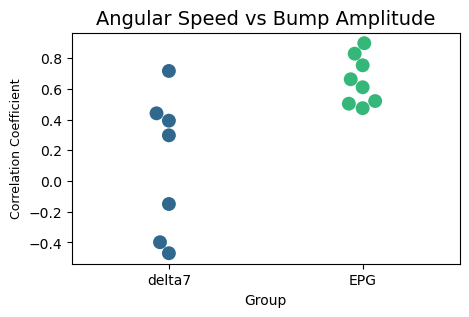

In [564]:

# Combine arrays and create a corresponding group array for swarmplot
data = np.concatenate([ delta7_correlation_coefficient, EPG_correlation_coefficient])
group = np.concatenate([['delta7'] * len(delta7_correlation_coefficient), ['EPG'] * len(EPG_correlation_coefficient)])

# Create a DataFrame for seaborn
df = pd.DataFrame({'Value': data, 'Group': group})

# Create swarmplot
plt.figure(figsize=(5, 3))
sns.swarmplot(x='Group', y='Value', data=df, palette='viridis', size=10)

# Set labels and title
plt.ylabel('Correlation Coefficient',size =9)
plt.title('Angular Speed vs Bump Amplitude',size = 14)
plt.show()
